# Titanic: Machine Learning from Disaster
This is my notebook for Kaggle's competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

I created [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and used [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to determine the best hyperparameters for three different classifiers: [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html).  
The goal of this competition is to predict which passengers on the Titanic survived.

### Notebook contents:
1. Get and Clean Data
2. Classifier Models
3. Create Pipelines
4. Grid Search
5. Comparing Models
6. Making Predictions

In [1]:
#Import libraries
import numpy as np 
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import f1_score, r2_score, confusion_matrix, accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sn
import matplotlib.pyplot as plt

## 1. Get and Clean Data

In [2]:
#Get the training data
df = pd.read_csv('../input/titanic/train.csv')
df.set_index('PassengerId', inplace=True)
display(df.head(),df.shape)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 11)

In [3]:
#Get summary descriptions for all features in dataset
with pd.option_context('display.max_columns', None):
    display(df.describe(include='all'))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### Create bar graphs and histograms to visualize the distribution of the features.

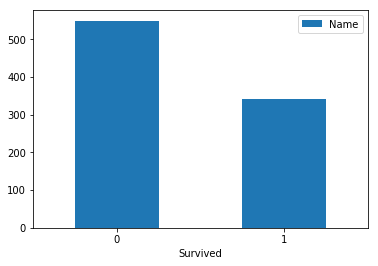

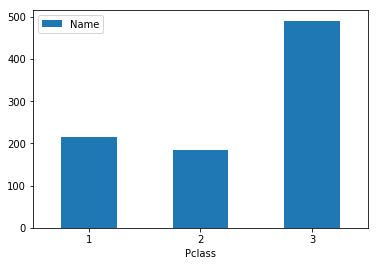

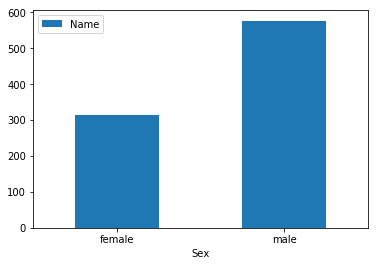

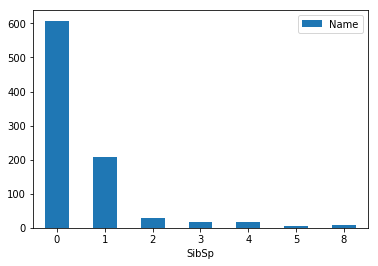

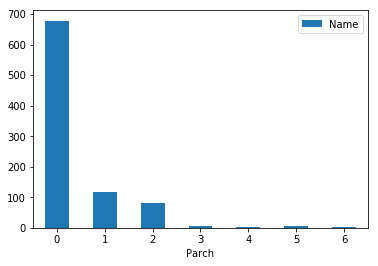

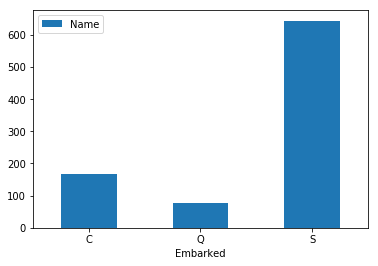

In [4]:
for col in ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    df.groupby(col).count().plot.bar(y='Name', rot=0)

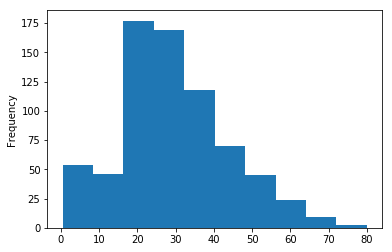

In [5]:
df['Age'].plot.hist()

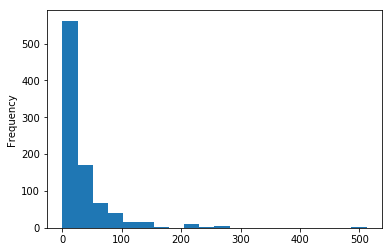

In [6]:
df['Fare'].plot.hist(bins=20)

In [7]:
#Get train and test sets
X = df.drop('Survived',axis = 1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

The ticket, cabin, and name features won't be of much use in classifying the individuals. Those will be dropped. Before testing the models, we will also encode the sex and embarked fetures.

In [8]:
#Clean up data
le = LabelEncoder()
X_train = X_train.drop(['Ticket','Cabin','Name'], axis=1)
X_train['Sex'] = le.fit_transform(X_train['Sex'])
X_train = pd.get_dummies(X_train, prefix='Embarked', columns=['Embarked'])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
686,2,1,25.0,1,2,41.5792,1,0,0
74,3,1,26.0,1,0,14.4542,1,0,0
883,3,0,22.0,0,0,10.5167,0,0,1
329,3,0,31.0,1,1,20.5250,0,0,1
454,1,1,49.0,1,0,89.1042,1,0,0


In [9]:
for col in X_train.columns:
    print('number of NaN values for the column', col, X_train[col].isnull().sum())

number of NaN values for the column Pclass 0
number of NaN values for the column Sex 0
number of NaN values for the column Age 117
number of NaN values for the column SibSp 0
number of NaN values for the column Parch 0
number of NaN values for the column Fare 0
number of NaN values for the column Embarked_C 0
number of NaN values for the column Embarked_Q 0
number of NaN values for the column Embarked_S 0


The only remaining column with null values is age. We'll use KNeighborsRegressor to impute the missing ages.  
The R^2 value using mean would be zero so we see that KNeighborsRegressor is an improvement over using the mean to impute the values.

In [10]:
#Try to predict age using KNeighbors
knc = KNeighborsRegressor(n_neighbors=2)
kfit=X_train.copy(deep=True)
no_age = kfit.loc[kfit['Age'].isna(),:].index
kfit2 = kfit.dropna()
knc.fit(kfit2.drop('Age',axis=1),kfit2['Age'])
print('R^2:',knc.score(kfit2.drop('Age',axis=1),kfit2['Age']))
predAge = knc.predict(kfit2.drop('Age',axis=1))
pd.DataFrame({'Predicted':np.around(predAge),'Actual':kfit2['Age'], 
              'Difference':kfit2['Age'].sub(np.around(predAge))})

R^2: 0.5123540336268885


,Predicted,Actual,Difference
PassengerId,,,
686,24.0,25.0,1.0
74,20.0,26.0,6.0
883,22.0,22.0,0.0
329,33.0,31.0,-2.0
454,44.0,49.0,5.0
...,...,...,...
72,12.0,16.0,4.0
107,33.0,21.0,-12.0
861,38.0,41.0,3.0


In [11]:
#Impute ages using KNN
display(kfit.loc[no_age,:].head())
ii = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=2))
kfit3 = pd.DataFrame(data=ii.fit_transform(kfit),columns=kfit.columns,index=kfit.index)
kfit3.loc[no_age,:].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
186,1,1,NaN,0,0,50.0000,0,0,1
548,2,1,NaN,0,0,13.8625,1,0,0
352,1,1,NaN,0,0,35.0000,0,0,1
265,3,0,NaN,0,0,7.7500,0,1,0
614,3,1,NaN,0,0,7.7500,0,1,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
186,1.0,1.0,27.50,0.0,0.0,50.0000,0.0,0.0,1.0
548,2.0,1.0,25.00,0.0,0.0,13.8625,1.0,0.0,0.0
352,1.0,1.0,46.00,0.0,0.0,35.0000,0.0,0.0,1.0
265,3.0,0.0,21.50,0.0,0.0,7.7500,0.0,1.0,0.0
614,3.0,1.0,51.25,0.0,0.0,7.7500,0.0,1.0,0.0


## 2. Classifier Models
Now we test the three chosen models, [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html), on the train set.

In [12]:
dtc = tree.DecisionTreeClassifier(random_state=15)
dtc.fit(kfit3,y_train)
print('Train score for Decision Tree:', round(dtc.score(kfit3,y_train),3))


Train score for Decision Tree: 0.98


In [13]:
rfc = RandomForestClassifier(random_state=15, n_estimators=10)
rfc.fit(kfit3,y_train)
print('Train score for Random Forest:', round(rfc.score(kfit3,y_train),3))

Train score for Random Forest: 0.968


In [14]:
xgb = XGBClassifier(random_state=15)
xgb.fit(kfit3,y_train)
print('Train score for XGB:', round(xgb.score(kfit3,y_train),3))

Train score for XGB: 0.891


## 3. Create Pipelines
The function transform_data uses Scikit Learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) and returns a dataframe.  
[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) and [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) is used to impute the missing ages.  
Then each classifier is assigned a pipleline.


In [15]:
#List of column names in order
column_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

#Separate transformer for one-hot encoding
OH_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])
#Using ColumnTransformer fill possible na values in any column
#Columns will be added in the order that they are listed here
column_trans = ColumnTransformer(
    [
        ('Pclass', SimpleImputer(strategy='most_frequent'), [column_names[0]]),
        ('Sex', OrdinalEncoder(), [column_names[1]]),
        ('Age', FunctionTransformer(validate=False), [column_names[2]]),#pass through for now fill in later
        ('SibSp', SimpleImputer(strategy='median'), [column_names[3]]),
        ('Parch', SimpleImputer(strategy='median'), [column_names[4]]),
        ('Fare', SimpleImputer(strategy='median'), [column_names[5]]),
        ('Embarked', OH_transformer, [column_names[6]])
    ],remainder='drop')

#Function transforms data and returns dataframe
def transform_data(X):
    Xa = column_trans.fit_transform(X)
    
    #Use KNN to impute remaining na values, Ages
    ii = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=2))
    Xt = ii.fit_transform(Xa)
    
    #Recreate dataframe
    X_df = pd.DataFrame(data= Xt, columns = column_names[0:6]+list(column_trans.named_transformers_[
        'Embarked'][1].get_feature_names()), index=X.index)
    return X_df


In [16]:
#Pipelines for each transformer

dtc_pipeline = Pipeline(steps=[
    ('transform', FunctionTransformer(transform_data, validate=False, check_inverse=False)),
    ('classification', tree.DecisionTreeClassifier(random_state=15))
])

rfc_pipeline = Pipeline(steps=[
    ('transform', FunctionTransformer(transform_data, validate=False, check_inverse=False)),
    ('classification', RandomForestClassifier(random_state=15))
])

xgb_pipeline = Pipeline(steps=[
    ('transform', FunctionTransformer(transform_data, validate=False, check_inverse=False)),
    ('classification', XGBClassifier(random_state=15))
])

## 4. Grid Search
Perform a grid search over select hyperparameters for the three chosen classifiers.

### DecisionTreeClassifier

In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=1/3, random_state=12)

In [18]:
#Create a list of parameters to use for grid search to allow for optional fine tuning of best parameters
dtc_parameters=[]
dtc_parameters.append({'classification__max_depth':list(range(2,10))+[None],
                       'classification__max_features':['auto','log2',None]
                      })

for i in range(len(dtc_parameters)):
    gs_dtc = GridSearchCV(dtc_pipeline, dtc_parameters[i], cv=5, iid=False)
    gs_dtc.fit(X_train2,y_train2)
    print("Best parameter (CV score=%0.3f):" % gs_dtc.best_score_)
    print(gs_dtc.best_params_)
    dtc_df = pd.DataFrame(gs_dtc.cv_results_)[
        ['rank_test_score','param_classification__max_depth', 'param_classification__max_features',
         'mean_test_score']].sort_values('rank_test_score')
    display(dtc_df.head())
    

Best parameter (CV score=0.832):
{'classification__max_depth': 4, 'classification__max_features': None}


,rank_test_score,param_classification__max_depth,param_classification__max_features,mean_test_score
8,1,4,None,0.831676
13,2,6,log2,0.826535
12,2,6,auto,0.826535
3,4,3,auto,0.824939
4,4,3,log2,0.824939


In [19]:
#Test the best combinations on the test set
cols = ['max_depth', 'max_features','CV Train Score', 'Accuracy Test score', 'f1 Test Score']
results_df = pd.DataFrame(columns=cols)
for row in dtc_df.head().iterrows():
    dtc_pipeline.set_params(classification__max_depth=row[1][1],
                            classification__max_features=row[1][2])
    dtc_pipeline.fit(X_train2,y_train2)
    dtc_preds = dtc_pipeline.predict(X_test2)
    results_df=results_df.append(pd.DataFrame([[row[1][1],row[1][2],round(row[1][3],3),
                      round(accuracy_score(y_test2,dtc_preds),3),round(f1_score(y_test2,dtc_preds),3)]],
                                             columns=cols, index=[row[1][0]]))
display(results_df)

,max_depth,max_features,CV Train Score,Accuracy Test score,f1 Test Score
1,4,None,0.832,0.774,0.660
2,6,log2,0.827,0.751,0.651
2,6,auto,0.827,0.751,0.651
4,3,auto,0.825,0.758,0.604
4,3,log2,0.825,0.758,0.604


In [20]:
#Fit using best parameters
dtc_pipeline.set_params(classification__max_depth=4,classification__max_features=None)
dtc_pipeline.fit(X_train2,y_train2)
dtc_preds = dtc_pipeline.predict(X_test2)
dtc_accuracy = round(accuracy_score(y_test2,dtc_preds),3)
dtc_testScore=round(f1_score(y_test2,dtc_preds),3)
print('Test set accuracy score:',dtc_accuracy)
print('Test set f1 score:',dtc_testScore)

Test set accuracy score: 0.774
Test set f1 score: 0.66


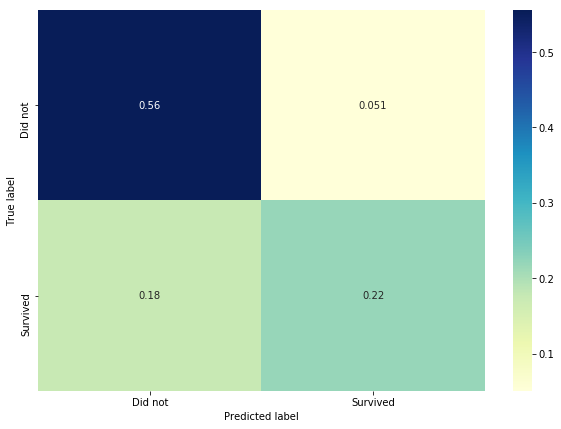

In [21]:
#Graph the confusion matrix for this model
cm = confusion_matrix(y_test2,dtc_preds)/len(dtc_preds)
plt.figure(figsize = (10,7))
ax = sn.heatmap(cm , annot=True, cmap='YlGnBu', xticklabels=['Did not','Survived'], yticklabels=['Did not','Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
#View feature importances for this model
display(pd.DataFrame(data=dtc_pipeline[1].feature_importances_,index= column_names[0:6]+list(column_trans.named_transformers_['Embarked'][1].get_feature_names()),columns=['Importance']).sort_values('Importance', ascending=False))

,Importance
Sex,0.606207
Pclass,0.131495
Age,0.083889
Fare,0.074428
SibSp,0.054488
x0_S,0.039865
Parch,0.005403
x0_C,0.004226
x0_Q,0.000000


### Random Forest Classifier

In [23]:
#Create a list of parameters to use for grid search to allow for optional fine tuning of best parameters
rfc_parameters=[]
rfc_df = []
rfc_parameters.append({'classification__n_estimators':np.arange(50,250,25),
                       'classification__max_depth':list(range(2,13))+[None],
                       'classification__max_features':['auto','log2',None]})

for i in range(len(rfc_parameters)):
    gs_rfc = GridSearchCV(rfc_pipeline, rfc_parameters[i], cv=5, iid=False)
    gs_rfc.fit(X_train2,y_train2)
    rfc_df.append(pd.DataFrame(gs_rfc.cv_results_)[
        ['rank_test_score','param_classification__n_estimators','param_classification__max_depth',
         'param_classification__max_features','mean_test_score']].sort_values('rank_test_score'))
    display(rfc_df[i].head(10))

,rank_test_score,param_classification__n_estimators,param_classification__max_depth,param_classification__max_features,mean_test_score
181,1,175,9,log2,0.855234
173,1,175,9,auto,0.855234
170,3,100,9,auto,0.853568
178,3,100,9,log2,0.853568
153,5,75,8,log2,0.851901
195,5,125,10,auto,0.851901
145,5,75,8,auto,0.851901
203,5,125,10,log2,0.851901
183,9,225,9,log2,0.851873
175,9,225,9,auto,0.851873


In [24]:
#Test the best combinations on the test set
cols = ['n_estimators','max_depth', 'max_features','CV Train Score', 'Accuracy Test score', 'f1 Test Score']
results_df = pd.DataFrame(columns=cols)

for i in range(len(rfc_df)):
    for row in rfc_df[i].head(10).iterrows():
        rfc_pipeline.set_params(classification__n_estimators=row[1][1],
                               classification__max_depth=row[1][2],
                               classification__max_features=row[1][3])
        rfc_pipeline.fit(X_train2,y_train2)
        rfc_preds = rfc_pipeline.predict(X_test2)
        results_df=results_df.append(pd.DataFrame([[row[1][1],row[1][2],row[1][3],
                                                    round(row[1][4],3),
                                                    round(accuracy_score(y_test2,rfc_preds),3),
                                                    round(f1_score(y_test2,rfc_preds),3)]],
                                                  columns=cols, index=[row[1][0]]))
    display(results_df)

,n_estimators,max_depth,max_features,CV Train Score,Accuracy Test score,f1 Test Score
1,175,9,log2,0.855,0.795,0.708
1,175,9,auto,0.855,0.795,0.708
3,100,9,auto,0.854,0.795,0.705
3,100,9,log2,0.854,0.795,0.705
5,75,8,log2,0.852,0.795,0.702
5,125,10,auto,0.852,0.791,0.708
5,75,8,auto,0.852,0.795,0.702
5,125,10,log2,0.852,0.791,0.708
9,225,9,log2,0.852,0.788,0.701
9,225,9,auto,0.852,0.788,0.701


In [25]:
#Fit using best parameters
rfc_pipeline.set_params(classification__n_estimators=175 ,classification__max_depth=9,
                        classification__max_features='log2')
rfc_pipeline.fit(X_train2,y_train2)
rfc_preds = rfc_pipeline.predict(X_test2)
rfc_accuracy = round(accuracy_score(y_test2,rfc_preds),3)
rfc_testScore=round(f1_score(y_test2,rfc_preds),3)
print('Test set accuracy score:', rfc_accuracy)
print('Test set f1 score:',rfc_testScore)

Test set accuracy score: 0.795
Test set f1 score: 0.708


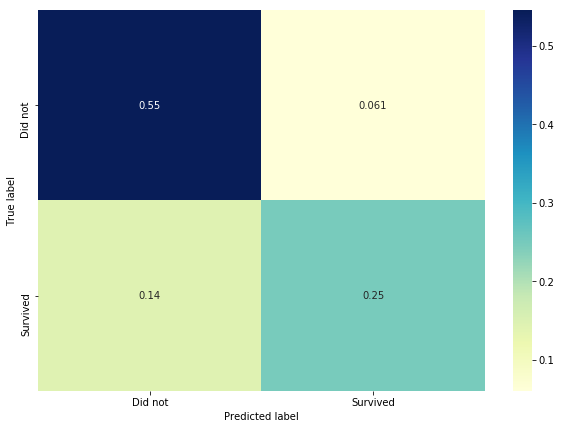

In [26]:
#Graph the confusion matrix for this model
cm = confusion_matrix(y_test2,rfc_preds)/len(rfc_preds)
plt.figure(figsize = (10,7))
ax = sn.heatmap(cm , annot=True, cmap='YlGnBu', xticklabels=['Did not','Survived'], yticklabels=['Did not','Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
#View feature importances for this model
display(pd.DataFrame(data=rfc_pipeline[1].feature_importances_,index= column_names[0:6]+list(column_trans.named_transformers_['Embarked'][1].get_feature_names()),columns=['Importance']).sort_values('Importance', ascending=False))

,Importance
Sex,0.351058
Fare,0.209476
Age,0.202839
Pclass,0.108581
SibSp,0.051758
Parch,0.036359
x0_S,0.016159
x0_C,0.013147
x0_Q,0.010623


### XGBoost Classifier

In [28]:
#Create a list of parameters to use for grid search to allow for optional fine tuning of best parameters
xgb_parameters=[]
xgb_df = []
xgb_parameters.append({'classification__learning_rate':
                       list(np.linspace(0.001,0.009,9))+list(np.linspace(0.01,0.09,9))+list(np.linspace(0.1,1,10)),
              'classification__n_estimators':np.arange(50,1000,50)})
xgb_parameters.append({'classification__learning_rate':np.linspace(0.01,0.025,7),
              'classification__n_estimators':np.arange(200,500,25)})
xgb_parameters.append({'classification__learning_rate':np.linspace(0.004,0.007,13),
              'classification__n_estimators':np.arange(500,900,25)})
for i in range(len(xgb_parameters)):
    gs_xgb = GridSearchCV(xgb_pipeline, xgb_parameters[i], cv=5, iid=False)
    gs_xgb.fit(X_train2,y_train2)
    xgb_df.append(pd.DataFrame(gs_xgb.cv_results_)[
        ['rank_test_score','param_classification__learning_rate', 'param_classification__n_estimators',
         'mean_test_score']].sort_values('rank_test_score'))
    display(xgb_df[i].head(15))

,rank_test_score,param_classification__learning_rate,param_classification__n_estimators,mean_test_score
180,1,0.01,500,0.845150
162,1,0.009,550,0.845150
128,1,0.007,750,0.845150
194,1,0.02,250,0.845150
111,1,0.006,850,0.845150
141,6,0.008,450,0.845122
177,6,0.01,350,0.845122
123,6,0.007,500,0.845122
72,6,0.004,800,0.845122
73,6,0.004,850,0.845122


,rank_test_score,param_classification__learning_rate,param_classification__n_estimators,mean_test_score
20,1,0.0125,400,0.845150
50,1,0.02,250,0.845150
49,1,0.02,225,0.845150
28,1,0.015,300,0.845150
11,1,0.01,475,0.845150
36,6,0.0175,200,0.845122
15,6,0.0125,275,0.845122
25,6,0.015,225,0.845122
6,6,0.01,350,0.845122
5,6,0.01,325,0.845122


,rank_test_score,param_classification__learning_rate,param_classification__n_estimators,mean_test_score
125,1,0.00575,825,0.84515
171,1,0.0065,775,0.84515
172,1,0.0065,800,0.84515
173,1,0.0065,825,0.84515
158,1,0.00625,850,0.84515
157,1,0.00625,825,0.84515
156,1,0.00625,800,0.84515
201,1,0.007,725,0.84515
202,1,0.007,750,0.84515
143,1,0.006,875,0.84515


In [29]:
#Test the best combinations on the test set
cols = ['learning_rate','n_estimators','CV Train Score', 'Accuracy Test score', 'f1 Test Score']
results_df = []

for i in range(len(xgb_df)):
    results_df.append(pd.DataFrame(columns=cols))
    for row in xgb_df[i].head(20).iterrows():
        xgb_pipeline.set_params(classification__learning_rate=row[1][1],
                                classification__n_estimators=row[1][2])
        xgb_pipeline.fit(X_train2,y_train2)
        xgb_preds = xgb_pipeline.predict(X_test2)

        results_df[i]=results_df[i].append(pd.DataFrame([[round(row[1][1],5),row[1][2],
                                                    round(row[1][3],3),
                                                    round(accuracy_score(y_test2,xgb_preds),3),
                                                    round(f1_score(y_test2,xgb_preds),3)]],
                                                  columns=cols, index=[row[1][0]]))
    display(results_df[i].sort_values(['Accuracy Test score', 'f1 Test Score','CV Train Score'],ascending=False))

,learning_rate,n_estimators,CV Train Score,Accuracy Test score,f1 Test Score
6,0.004,900,0.845,0.795,0.700
6,0.006,600,0.845,0.795,0.700
6,0.007,500,0.845,0.791,0.696
6,0.004,800,0.845,0.791,0.696
6,0.004,850,0.845,0.791,0.696
6,0.008,450,0.845,0.791,0.693
6,0.010,350,0.845,0.791,0.693
6,0.009,400,0.845,0.791,0.693
6,0.005,700,0.845,0.791,0.693
6,0.006,550,0.845,0.788,0.693


,learning_rate,n_estimators,CV Train Score,Accuracy Test score,f1 Test Score
14,0.0125,225,0.843,0.798,0.712
14,0.0100,275,0.843,0.795,0.705
6,0.0125,275,0.845,0.791,0.696
6,0.0100,325,0.845,0.791,0.696
14,0.0150,200,0.843,0.791,0.696
14,0.0125,250,0.843,0.791,0.696
14,0.0100,300,0.843,0.791,0.696
1,0.0200,225,0.845,0.791,0.693
6,0.0100,350,0.845,0.791,0.693
14,0.0125,300,0.843,0.791,0.693


,learning_rate,n_estimators,CV Train Score,Accuracy Test score,f1 Test Score
17,0.00475,675,0.845,0.791,0.696
17,0.00475,700,0.845,0.791,0.696
17,0.00475,725,0.845,0.791,0.696
17,0.00550,650,0.845,0.791,0.693
1,0.00575,825,0.845,0.788,0.690
1,0.00650,775,0.845,0.788,0.690
1,0.00650,800,0.845,0.788,0.690
1,0.00650,825,0.845,0.788,0.690
1,0.00625,850,0.845,0.788,0.690
1,0.00625,825,0.845,0.788,0.690


In [30]:
#Fit using best parameters 
xgb_pipeline.set_params(classification__learning_rate=0.0125,classification__n_estimators=225)
xgb_pipeline.fit(X_train2,y_train2)
xgb_preds = xgb_pipeline.predict(X_test2)
xgb_accuracy = round(accuracy_score(y_test2,xgb_preds),3)
xgb_testScore=round(f1_score(y_test2,xgb_preds),3)
print('Test set accuracy score:',xgb_accuracy)
print('Test set f1 score:',xgb_testScore)

Test set accuracy score: 0.798
Test set f1 score: 0.712


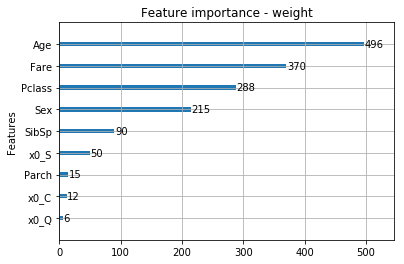

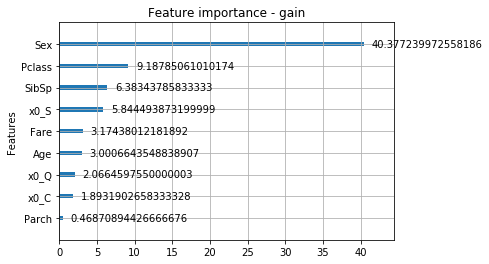

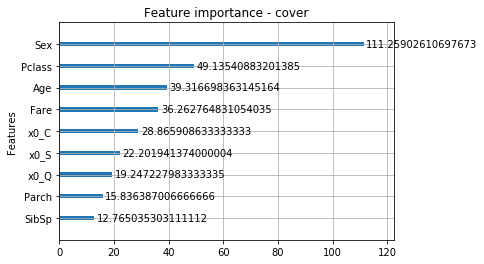

In [31]:
#Plot the graphs to show the three types of importances
from xgboost import plot_importance
for itype in ['weight','gain','cover']:
    plot_importance(xgb_pipeline[1],importance_type=itype,xlabel=None,title='Feature importance - '+itype)

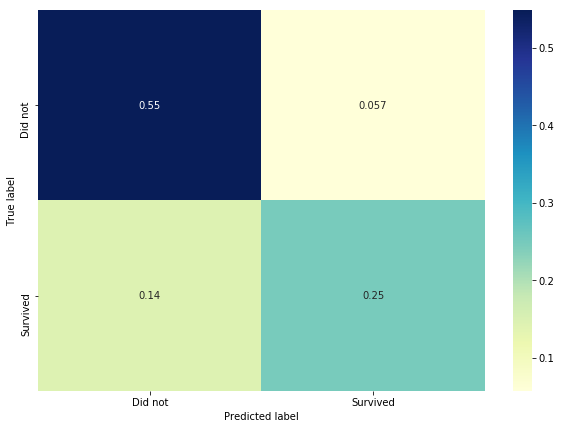

In [32]:
#Graph the confusion matrix for this model
cm = confusion_matrix(y_test2,xgb_preds)/len(xgb_preds)
plt.figure(figsize = (10,7))
ax = sn.heatmap(cm , annot=True, cmap='YlGnBu', xticklabels=['Did not','Survived'], yticklabels=['Did not','Survived'])

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

## 5. Comparing Models
We can see that Random Forest Classifier and XG Boost Classifier have close scores.  
The Decision Tree classifier did not score as well.

In [33]:
pd.DataFrame(data=[[dtc_accuracy,dtc_testScore],
                    [rfc_accuracy, rfc_testScore],
                   [xgb_accuracy,xgb_testScore]],
             columns=['Accuracy Score on Test Set','f1 Score on Test Set'],
             index=['Decision Tree','Random Forest','XG Boost'])

,Accuracy Score on Test Set,f1 Score on Test Set
Decision Tree,0.774,0.660
Random Forest,0.795,0.708
XG Boost,0.798,0.712


## 6. Making Predictions
The Random Forest Classifier and XG Boost Classifier have similar scores. I will use both to create predictions and then compare the scores on the Kaggle test set.

In [34]:
#Read in the test set
df_test = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [35]:
#Make predictions using Random Forest Classifier and the best hyperparameters found by GridSearch
resultsRFC = rfc_pipeline.predict(df_test)
df_outRFC = pd.DataFrame(data=resultsRFC,columns=['Survived'],index=df_test.index)
df_outRFC.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [36]:
#Make predictions using XG Boost Classifier and the best hyperparameters found by GridSearch
resultsXGB = xgb_pipeline.predict(df_test)
df_outXGB = pd.DataFrame(data=resultsXGB,columns=['Survived'],index=df_test.index)
df_outXGB.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [37]:
#Just out of curiosity, let's take a look at where the two models disagree
df_test[df_outRFC['Survived']!=df_outXGB['Survived']].join(
    df_outXGB).rename(columns={'Survived':'XGB_Survived'}).sort_values(['Pclass','Name'])

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,XGB_Survived
PassengerId,,,,,,,,,,,
1198,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,0
1050,1,"Borebank, Mr. John James",male,42.0,0,0,110489,26.5500,D22,S,0
1040,1,"Crafton, Mr. John Bertram",male,NaN,0,0,113791,26.5500,NaN,S,0
1126,1,"Cumings, Mr. John Bradley",male,39.0,1,0,PC 17599,71.2833,C85,C,0
933,1,"Franklin, Mr. Thomas Parham",male,NaN,0,0,113778,26.5500,D34,S,0
1036,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.0,0,0,17475,26.5500,NaN,S,0
926,1,"Mock, Mr. Philipp Edmund",male,30.0,1,0,13236,57.7500,C78,C,1
1215,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.5500,NaN,S,0
956,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,0


In [38]:
#Create the files with predictions
df_outXGB.to_csv('resultsXGB.csv')
df_outRFC.to_csv('resultsRFC.csv')